In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

from matplotlib.colors import ListedColormap
import pandas as pd
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.base import clone
from sklearn.datasets import make_circles
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport, ROCAUC, ConfusionMatrix, DecisionBoundariesVisualizer

from BEKML import BEMKL

from utils import  evaluate_model, poly_kernel, gauss_kernel, scoring


sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100)
N = 1000
D = 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
rbf_init, rbf_end = -3, 7
ply_init, ply_end = 1, 4

kernel_attrs = [('rbf', 'all', i) for i in range(rbf_init, rbf_end)]
kernels = [lambda A, B: gauss_kernel(A, B, 2**i)
           for i in range(rbf_init, rbf_end)]

kernel_attrs += [('poly', 'all', i) for i in range(ply_init, ply_end)]
kernels += [lambda A, B: poly_kernel(A, B, 1, i)
            for i in range(ply_init, ply_end)]

kernel_attrs += [('rbf', j, i) for i in range(rbf_init, rbf_end)
                 for j in range(D)]
kernels += [lambda A, B: gauss_kernel(A[:, j:j+1], B[:, j:j+1], 2**i)
            for i in range(rbf_init, rbf_end) for j in range(D)]

kernel_attrs += [('poly', j, i) for i in range(ply_init, ply_end)
                 for j in range(D)]
kernels += [lambda A, B: poly_kernel(A[:, j:j+1], B[:, j:j+1], 1, i)
            for i in range(ply_init, ply_end) for j in range(D)]
len(kernels), len(kernel_attrs)

(39, 39)

# Clean Data

In [3]:
X, y = make_circles(N, factor=0.1, noise=0.01)
data = pd.DataFrame(X, columns=['x1', 'x2'])
y[y == 0] = -1
data['y'] = y

display(data.head())
data.describe()

,x1,x2,y
0,-0.259501,-0.960033,-1
1,1.001428,-0.081544,-1
2,0.091006,0.060759,1
3,0.000380,0.092492,1
4,-0.106336,-1.006802,-1


,x1,x2,y
count,1000.000000,1000.000000,1000.0000
mean,0.000067,0.000030,0.0000
std,0.503183,0.502956,1.0005
min,-1.022880,-1.017599,-1.0000
25%,-0.106199,-0.104115,-1.0000
50%,-0.000205,0.002066,0.0000
75%,0.106302,0.103624,1.0000
max,1.023531,1.015028,1.0000


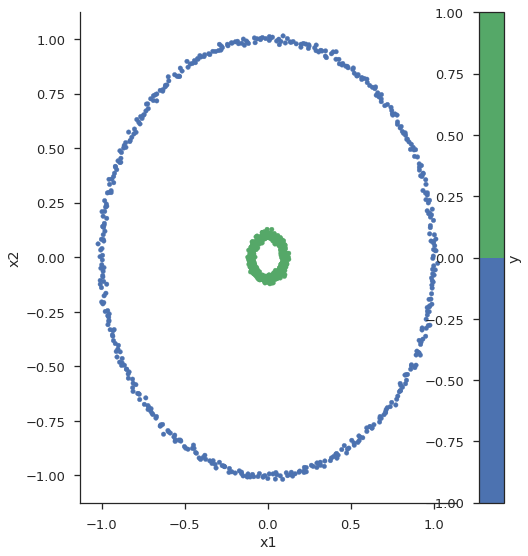

In [4]:
cmap = [(0.29803921568627451, 0.44705882352941179, 0.69019607843137254),
        (0.33333333333333331, 0.6588235294117647, 0.40784313725490196)]
cmap = ListedColormap(cmap)
ax = plt.figure(figsize=(8, 8)).gca()
data.plot.scatter('x1', 'x2', c='y', cmap=cmap, ax=ax)
sns.despine()
plt.tight_layout()

## Sparse Model

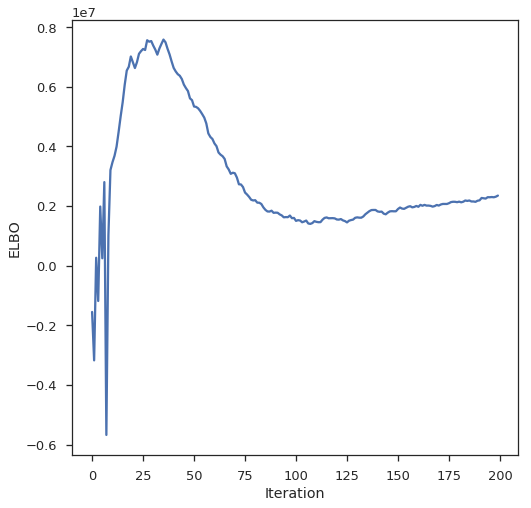

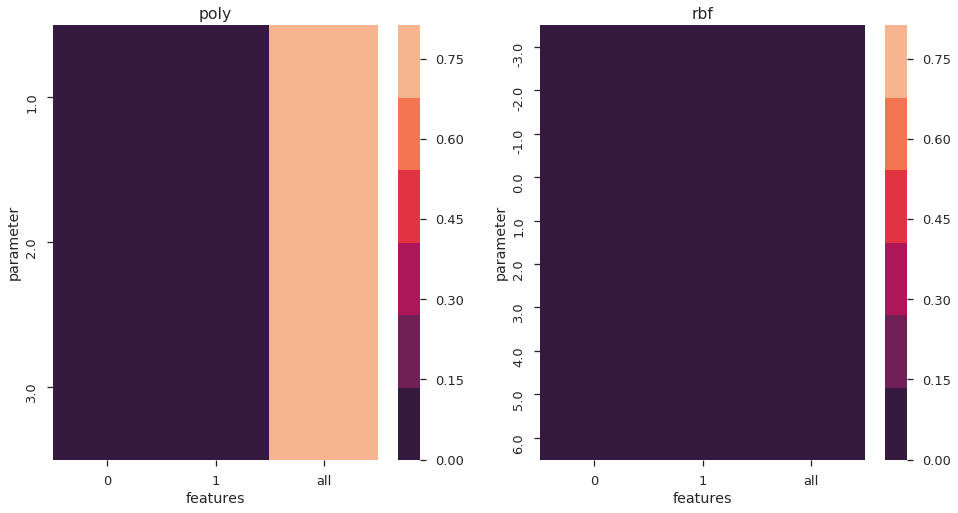

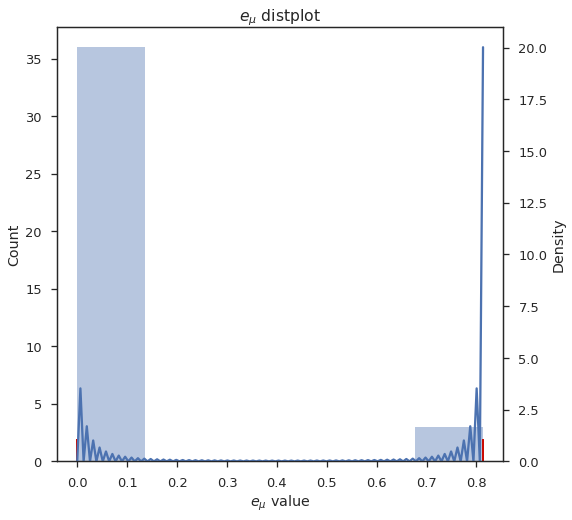

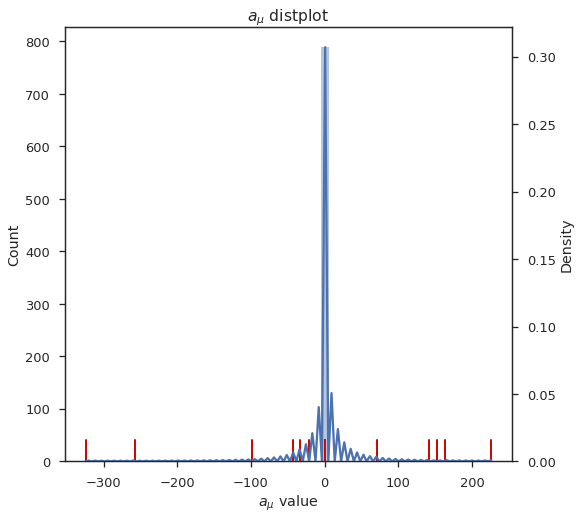

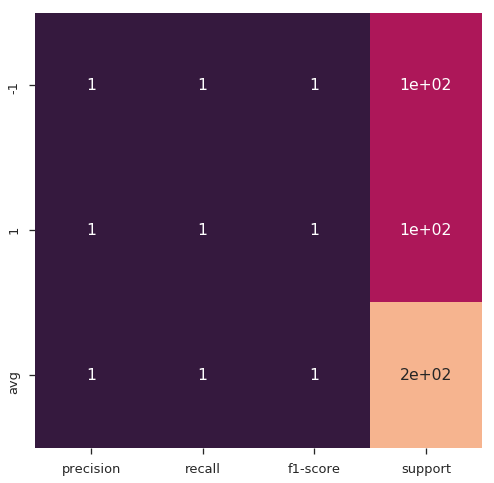

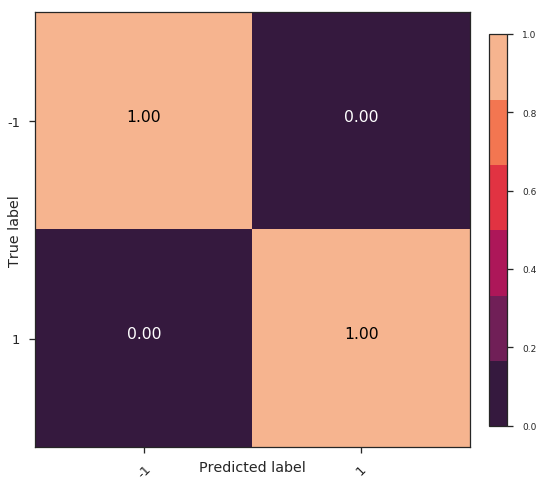

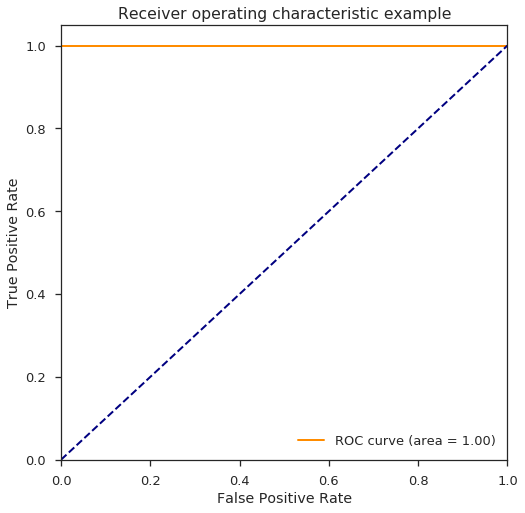

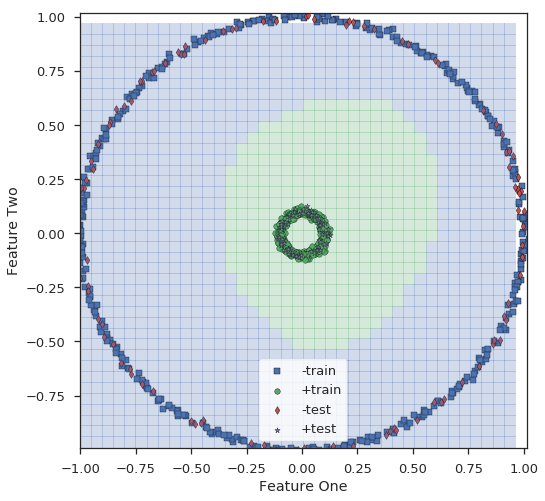

0 - Kernels: 3/39 (0.07692307692307693). SV: 660/666 (0.990990990990991). Mean e: 0.0639. Median e: 0.0000. Std e: 0.2212. 
1 - Kernels: 3/39 (0.07692307692307693). SV: 654/666 (0.9819819819819819). Mean e: 0.0629. Median e: 0.0000. Std e: 0.2179. 
2 - Kernels: 3/39 (0.07692307692307693). SV: 658/668 (0.9850299401197605). Mean e: 0.0629. Median e: 0.0000. Std e: 0.2177. 
3 - Kernels: 3/39 (0.07692307692307693). SV: 656/666 (0.984984984984985). Mean e: 0.0633. Median e: 0.0000. Std e: 0.2193. 
4 - Kernels: 3/39 (0.07692307692307693). SV: 658/666 (0.987987987987988). Mean e: 0.0634. Median e: 0.0000. Std e: 0.2197. 
5 - Kernels: 3/39 (0.07692307692307693). SV: 661/668 (0.9895209580838323). Mean e: 0.0632. Median e: 0.0000. Std e: 0.2191. 


/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 12.8825,  11.9756,  12.3542,  12.1979,  12.5057,  11.9261]),
 'score_time': array([ 1.314 ,  1.3149,  1.3149,  1.3095,  1.3338,  1.33  ]),
 'test_score': array([ 1.,  1.,  1.,  1.,  1.,  1.]),
 'train_score': array([ 1.,  1.,  1.,  1.,  1.,  1.])}

In [5]:
cc_sparse_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                        beta_gamma=1, alpha_omega=1e-11, beta_omega=1e+9,
                        e_null_thrsh=1e-3, a_null_thrsh=1e-3,
                        filter_kernels=False, filter_sv=False,
                        verbose=False)
evaluate_model(cc_sparse_model, X, y, kernel_attrs)

## Dense Model

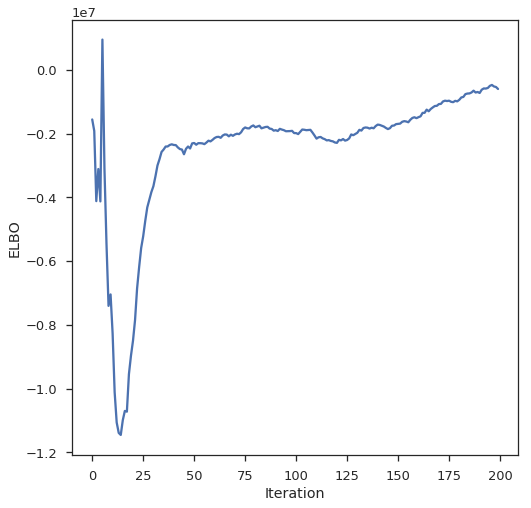

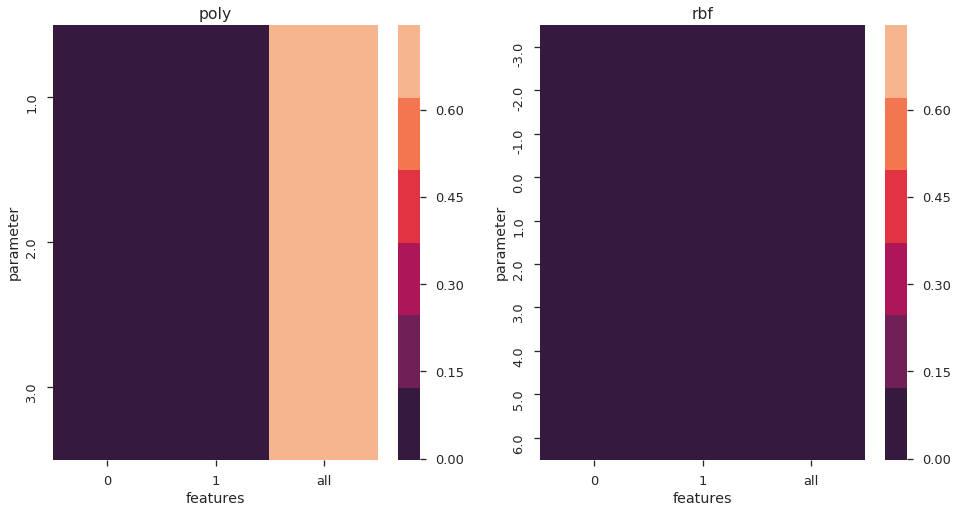

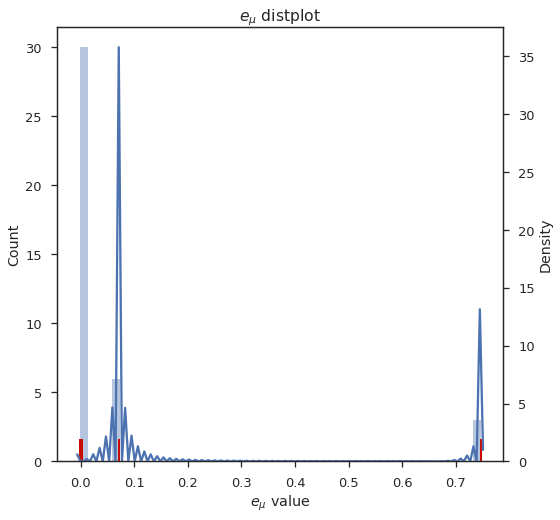

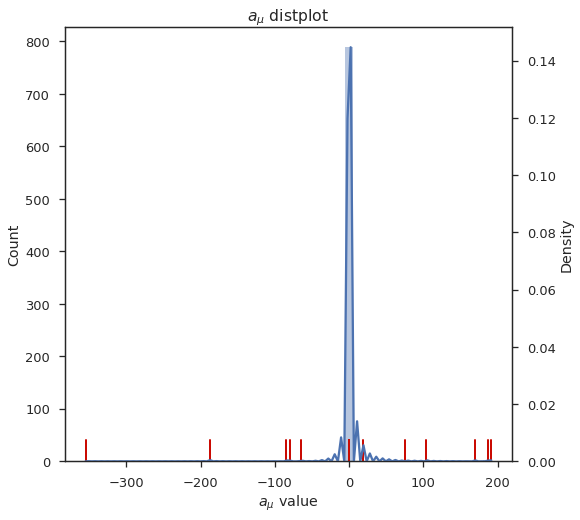

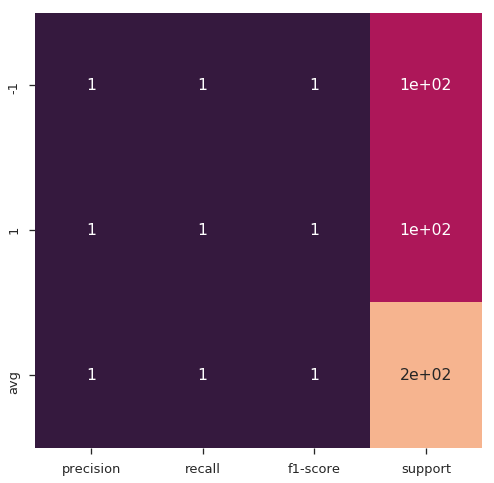

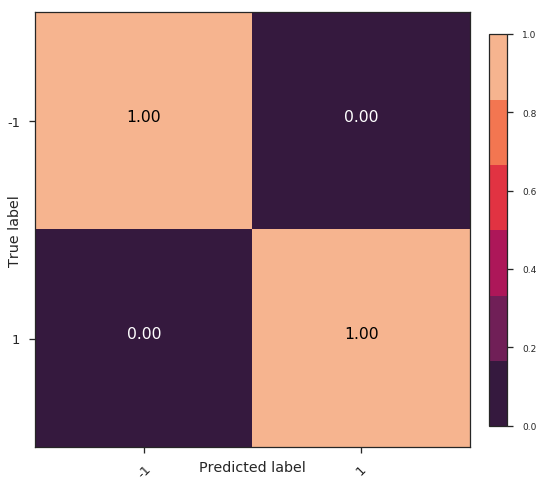

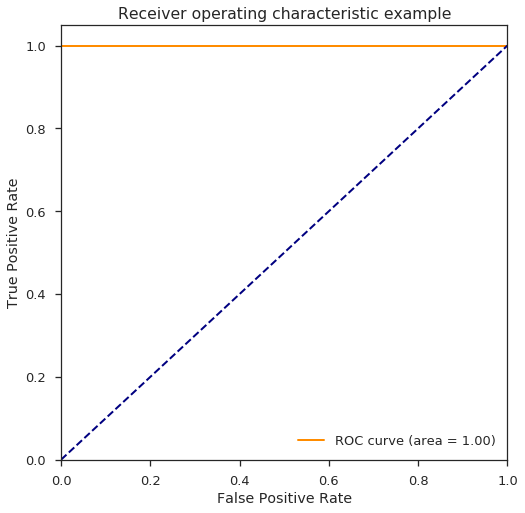

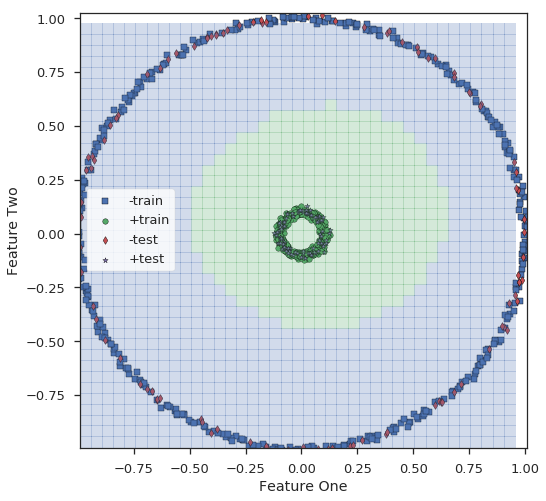

0 - Kernels: 39/39 (1.0). SV: 660/666 (0.990990990990991). Mean e: 0.0691. Median e: -0.0022. Std e: 0.2002. 
1 - Kernels: 39/39 (1.0). SV: 661/666 (0.9924924924924925). Mean e: 0.0694. Median e: -0.0033. Std e: 0.2031. 
2 - Kernels: 39/39 (1.0). SV: 663/668 (0.9925149700598802). Mean e: 0.0691. Median e: -0.0018. Std e: 0.1963. 
3 - Kernels: 39/39 (1.0). SV: 655/666 (0.9834834834834835). Mean e: 0.0682. Median e: -0.0028. Std e: 0.1972. 
4 - Kernels: 39/39 (1.0). SV: 661/666 (0.9924924924924925). Mean e: 0.0694. Median e: -0.0028. Std e: 0.2035. 
5 - Kernels: 39/39 (1.0). SV: 653/668 (0.9775449101796407). Mean e: 0.0694. Median e: -0.0023. Std e: 0.2011. 


/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 11.7801,  11.8188,  11.9815,  11.9574,  11.8375,  11.8203]),
 'score_time': array([ 1.3183,  1.3165,  1.3116,  1.3003,  1.3037,  1.3164]),
 'test_score': array([ 1.,  1.,  1.,  1.,  1.,  1.]),
 'train_score': array([ 1.,  1.,  1.,  1.,  1.,  1.])}

In [6]:
cc_normal_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                        beta_gamma=1, alpha_omega=1, beta_omega=1,
                        e_null_thrsh=1e-3, a_null_thrsh=1e-3,
                        filter_kernels=False, filter_sv=False,
                        verbose=False)
evaluate_model(cc_normal_model, X, y, kernel_attrs)

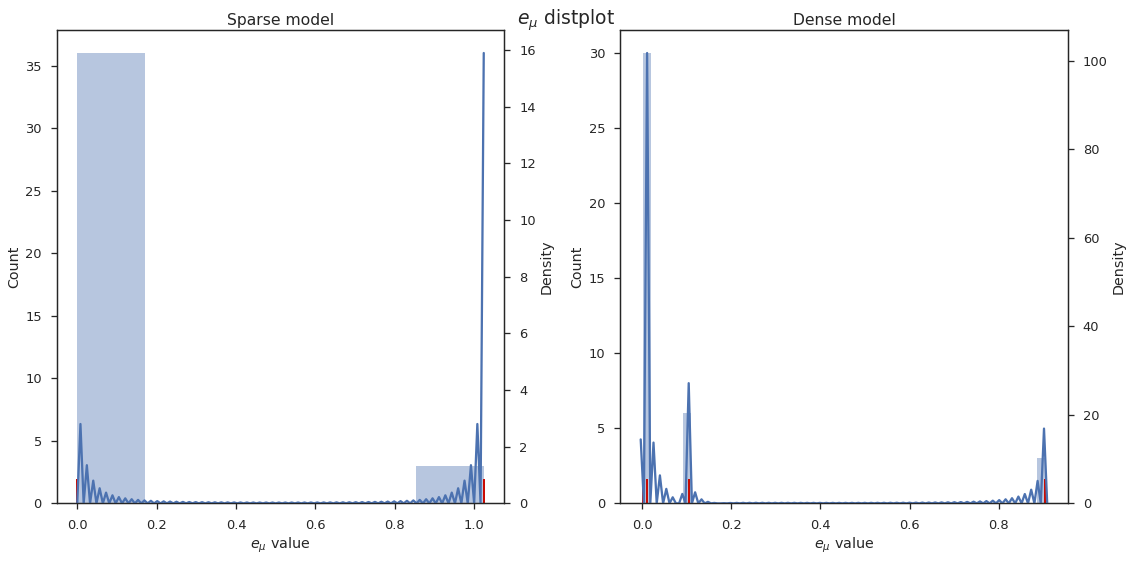

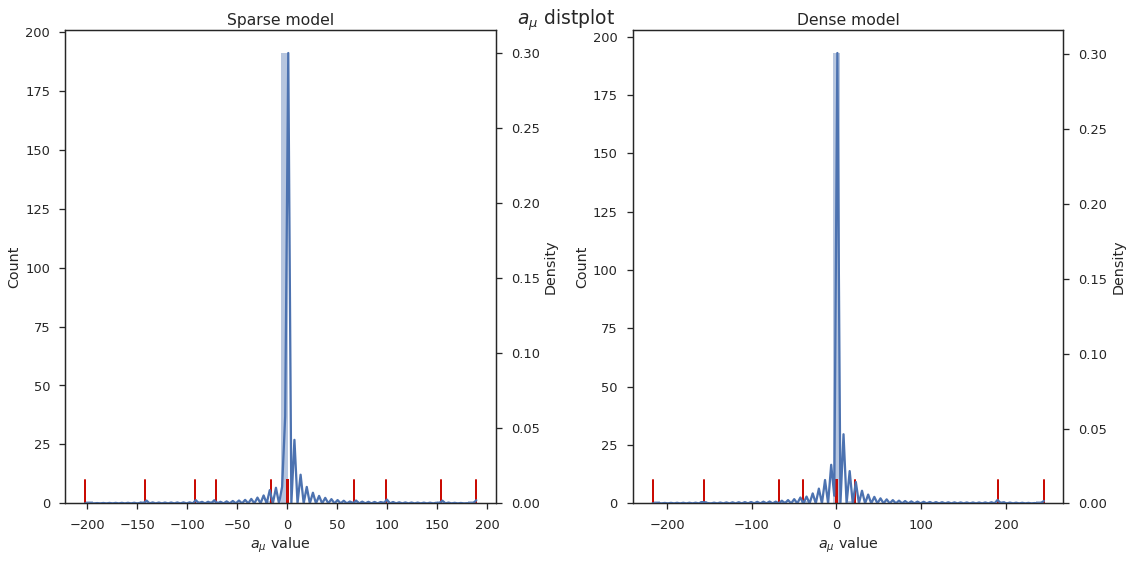

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1, ax2 = axes
cc_sparse_model.plot_e(ax=ax1, rug=True,
                       rug_kws={'color': 'r', 'linewidth': 2,
                                'alpha': 1})
cc_normal_model.plot_e(ax=ax2, rug=True,
                       rug_kws={'color': 'r', 'linewidth': 2,
                                'alpha': 1})
ax1.set_title('Sparse model')
ax2.set_title('Dense model')
fig.suptitle(r'$e_\mu$ distplot')
plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1, ax2 = axes
cc_sparse_model.plot_a(ax=ax1, rug=True,
                       rug_kws={'color': 'r', 'linewidth': 2,
                                'alpha': 1})
cc_normal_model.plot_a(ax=ax2, rug=True,
                       rug_kws={'color': 'r', 'linewidth': 2,
                                'alpha': 1})
ax1.set_title('Sparse model')
ax2.set_title('Dense model')
fig.suptitle(r'$a_\mu$ distplot')
plt.tight_layout()

# Noisy Data

In [9]:
X, y = make_circles(N, noise=0.2, factor=0.3)
data = pd.DataFrame(X, columns=['x1', 'x2'])
y[y == 0] = -1
data['y'] = y
display(data.head())
data.describe()

,x1,x2,y
0,-0.152990,0.569077,1
1,1.050890,-0.351662,-1
2,-0.337954,0.085155,1
3,0.220893,-0.720309,-1
4,-0.967427,-0.514264,-1


,x1,x2,y
count,1000.000000,1000.000000,1000.0000
mean,-0.007761,-0.005734,0.0000
std,0.562473,0.565709,1.0005
min,-1.373371,-1.639914,-1.0000
25%,-0.359513,-0.351142,-1.0000
50%,-0.009381,-0.012494,0.0000
75%,0.356509,0.359412,1.0000
max,1.648679,1.591637,1.0000


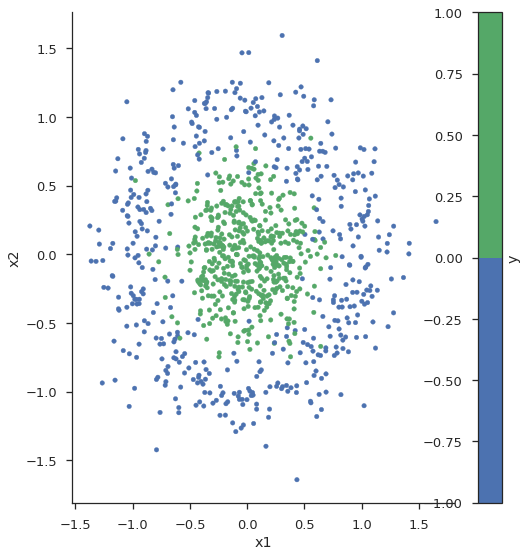

In [10]:
cmap = [(0.29803921568627451, 0.44705882352941179, 0.69019607843137254),
        (0.33333333333333331, 0.6588235294117647, 0.40784313725490196)]
cmap = ListedColormap(cmap)
ax = plt.figure(figsize=(8, 8)).gca()
data.plot.scatter('x1', 'x2', c='y', cmap=cmap, ax=ax)
sns.despine()
plt.tight_layout()

## Sparse Model

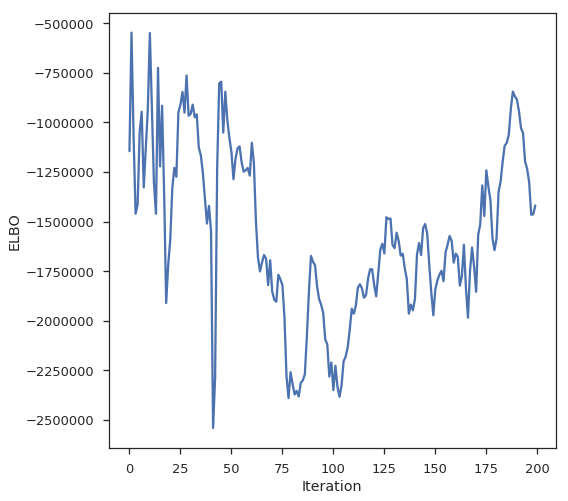

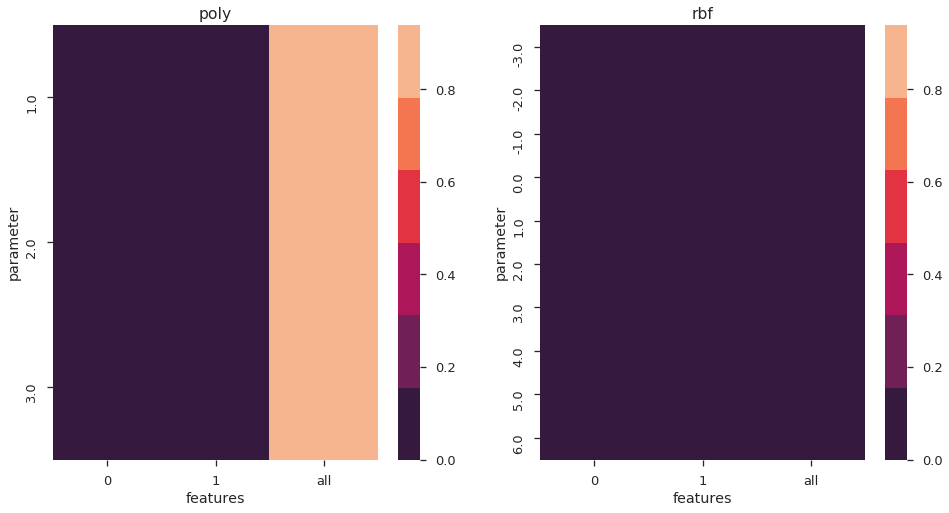

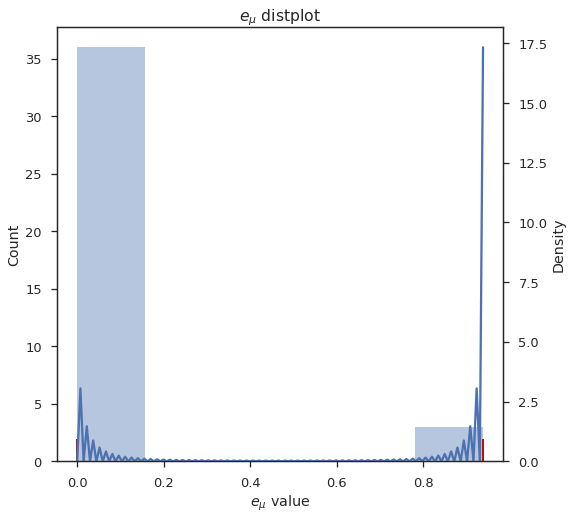

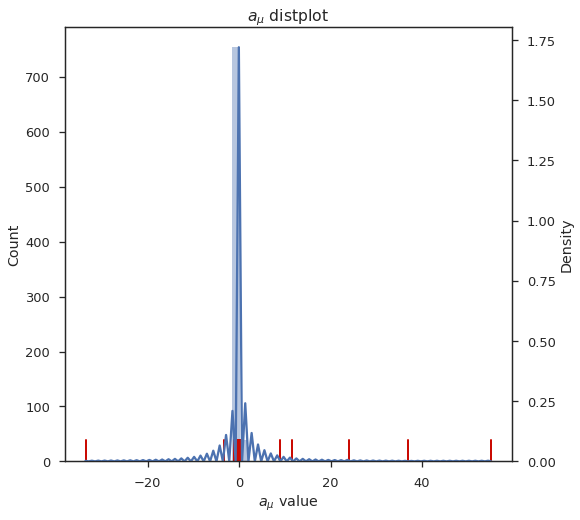

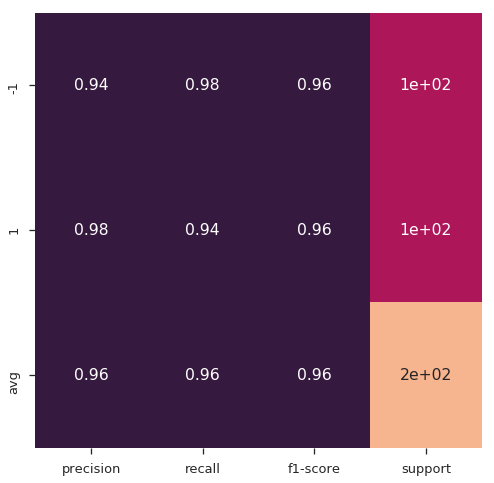

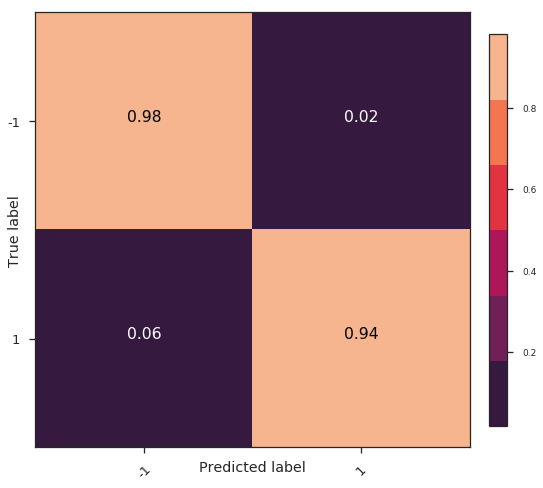

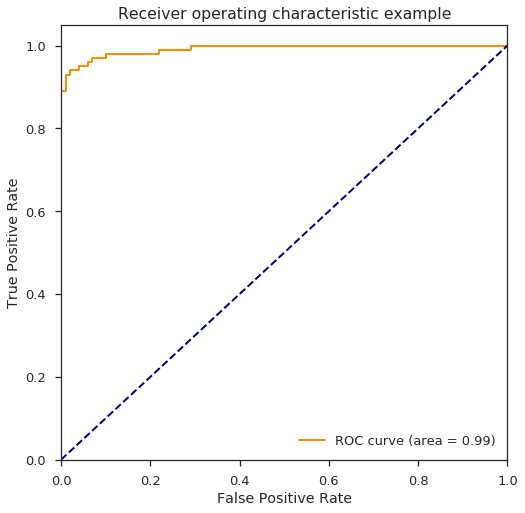

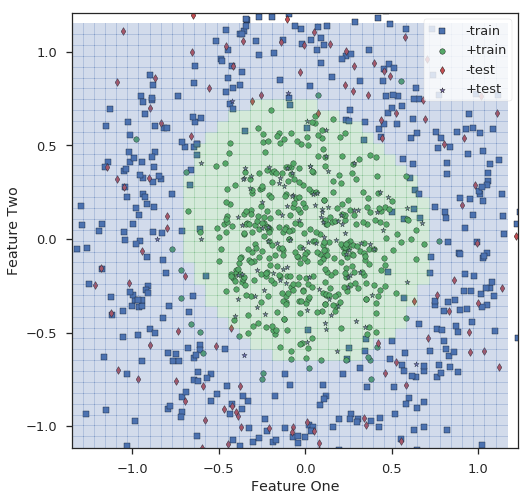

0 - Kernels: 3/39 (0.07692307692307693). SV: 661/666 (0.9924924924924925). Mean e: 0.0712. Median e: 0.0000. Std e: 0.2466. 
1 - Kernels: 3/39 (0.07692307692307693). SV: 666/666 (1.0). Mean e: 0.0762. Median e: 0.0000. Std e: 0.2638. 
2 - Kernels: 3/39 (0.07692307692307693). SV: 663/668 (0.9925149700598802). Mean e: 0.0724. Median e: 0.0000. Std e: 0.2507. 
3 - Kernels: 3/39 (0.07692307692307693). SV: 664/666 (0.996996996996997). Mean e: 0.0727. Median e: 0.0000. Std e: 0.2519. 
4 - Kernels: 3/39 (0.07692307692307693). SV: 663/666 (0.9954954954954955). Mean e: 0.0726. Median e: 0.0000. Std e: 0.2515. 
5 - Kernels: 3/39 (0.07692307692307693). SV: 667/668 (0.9985029940119761). Mean e: 0.0741. Median e: 0.0000. Std e: 0.2568. 


/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 15.214 ,  14.5046,  12.0302,  12.9477,  12.7263,  12.7385]),
 'score_time': array([ 1.4444,  1.3596,  1.3518,  1.3615,  1.3529,  1.3926]),
 'test_score': array([ 0.9551,  0.9551,  0.9518,  0.9431,  0.9461,  0.9518]),
 'train_score': array([ 0.9489,  0.9535,  0.9476,  0.958 ,  0.961 ,  0.9566])}

In [11]:
cn_sparse_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                        beta_gamma=1, alpha_omega=1e-11, beta_omega=1e+9,
                        e_null_thrsh=1e-3, a_null_thrsh=1e-3,
                        filter_kernels=False, filter_sv=False,
                        verbose=False)
evaluate_model(cn_sparse_model, X, y, kernel_attrs)

## Dense Model

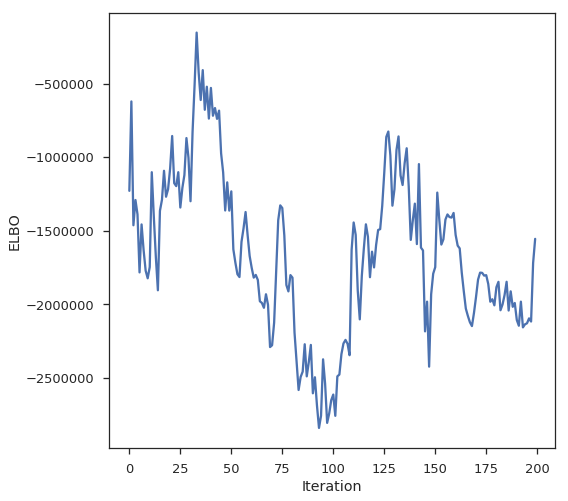

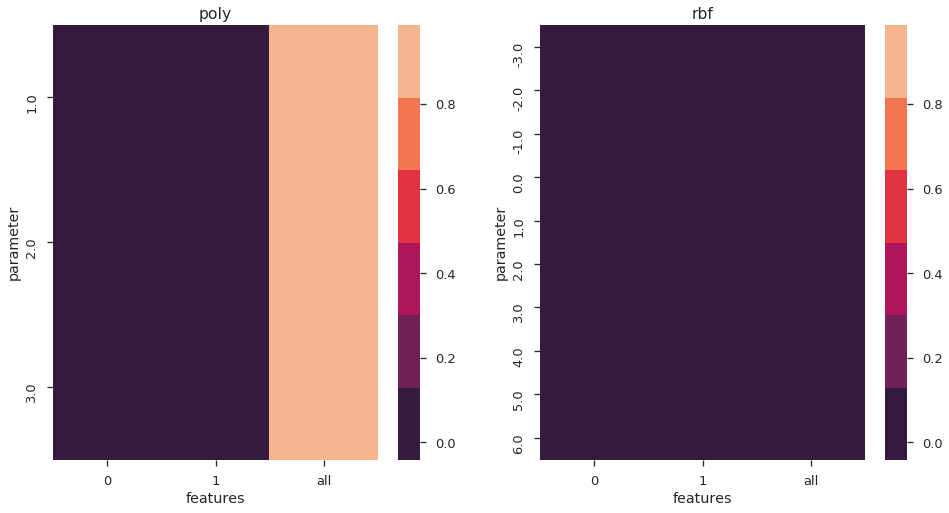

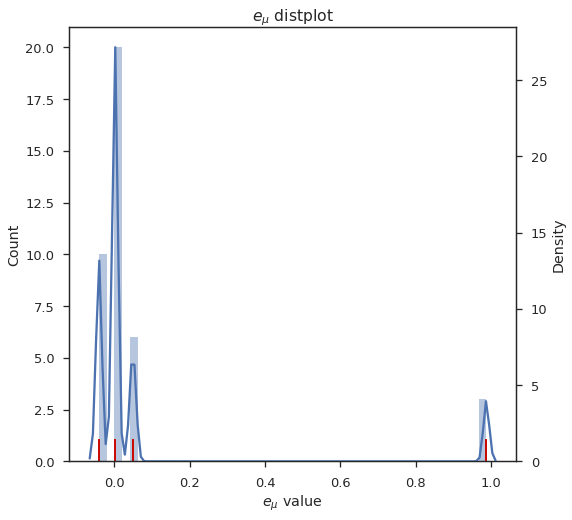

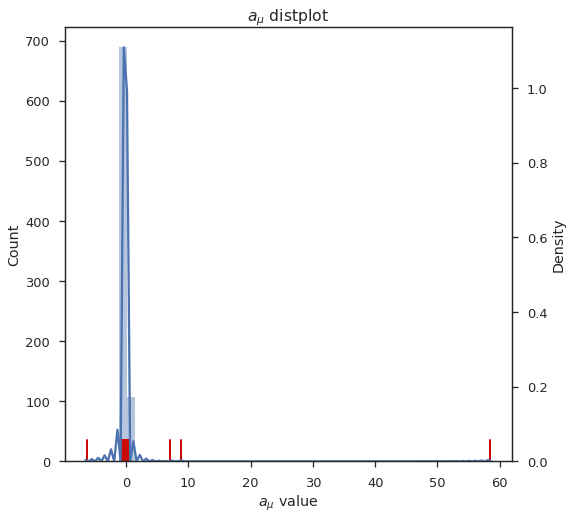

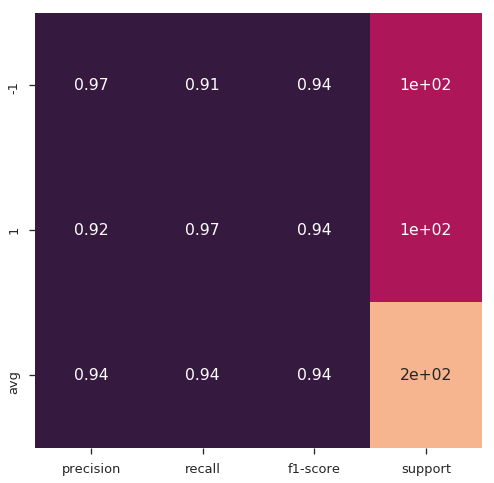

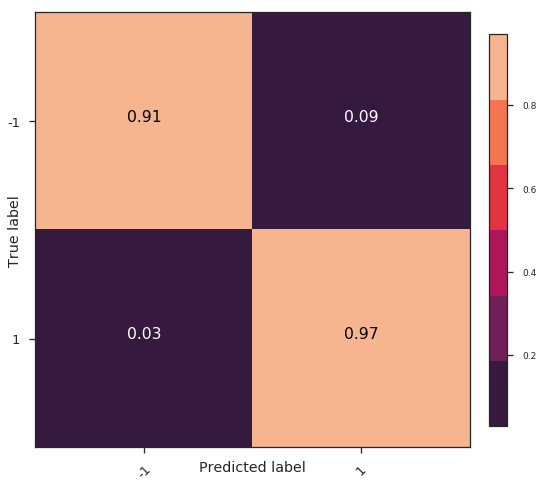

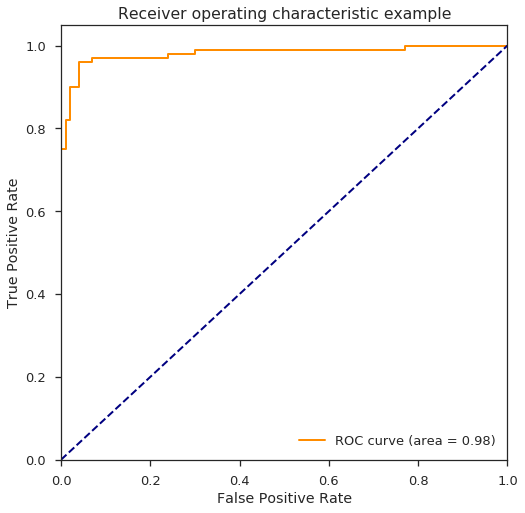

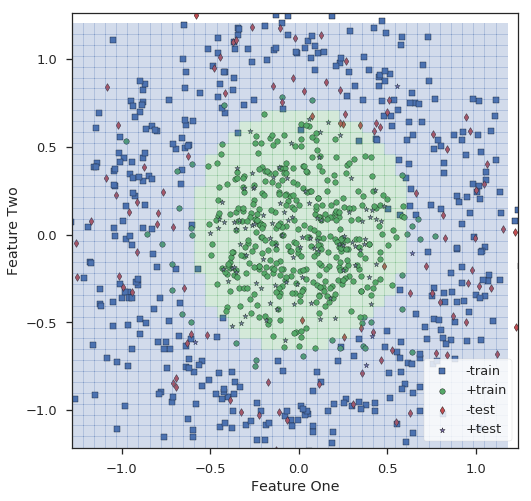

0 - Kernels: 39/39 (1.0). SV: 665/666 (0.9984984984984985). Mean e: 0.0514. Median e: -0.0102. Std e: 0.2393. 
1 - Kernels: 39/39 (1.0). SV: 665/666 (0.9984984984984985). Mean e: 0.0813. Median e: 0.0111. Std e: 0.2442. 
2 - Kernels: 39/39 (1.0). SV: 663/668 (0.9925149700598802). Mean e: 0.0782. Median e: 0.0036. Std e: 0.2775. 
3 - Kernels: 19/39 (0.48717948717948717). SV: 666/666 (1.0). Mean e: 0.0664. Median e: 0.0000. Std e: 0.2395. 
4 - Kernels: 39/39 (1.0). SV: 666/666 (1.0). Mean e: 0.1037. Median e: 0.0152. Std e: 0.2435. 
5 - Kernels: 39/39 (1.0). SV: 667/668 (0.9985029940119761). Mean e: 0.0888. Median e: 0.0229. Std e: 0.2502. 


/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 14.7128,  12.7852,  12.998 ,  12.7548,  12.798 ,  12.2768]),
 'score_time': array([ 1.4185,  1.4009,  1.3498,  1.3754,  1.3487,  1.3311]),
 'test_score': array([ 0.9521,  0.9731,  0.9307,  0.9641,  0.9461,  0.9428]),
 'train_score': array([ 0.952 ,  0.9474,  0.9656,  0.952 ,  0.9535,  0.9581])}

In [12]:
cn_normal_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                        beta_gamma=1, alpha_omega=1, beta_omega=1,
                        e_null_thrsh=1e-3, a_null_thrsh=1e-3,
                        filter_kernels=False, filter_sv=False,
                        verbose=False)
evaluate_model(cn_normal_model, X, y, kernel_attrs)

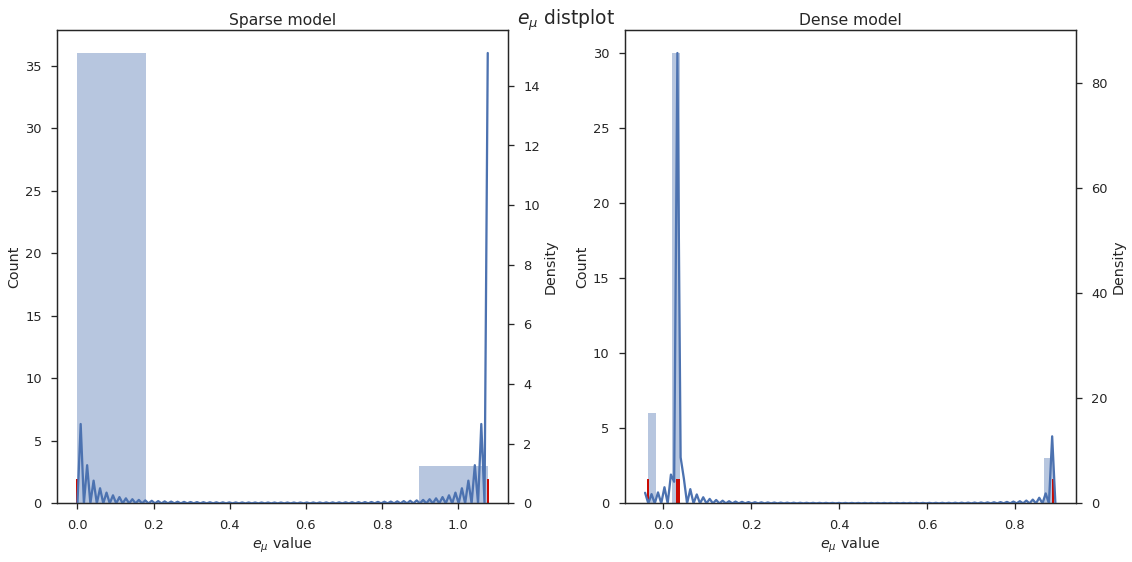

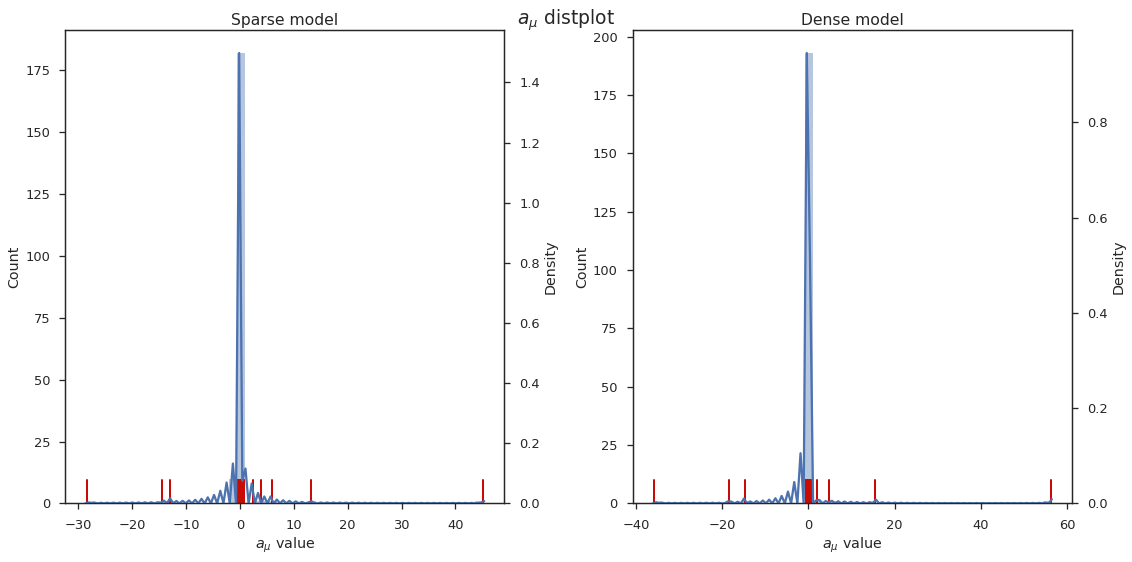

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1, ax2 = axes
cn_sparse_model.plot_e(ax=ax1, rug=True,
                       rug_kws={'color': 'r', 'linewidth': 2,
                                'alpha': 1})
cn_normal_model.plot_e(ax=ax2, rug=True,
                       rug_kws={'color': 'r', 'linewidth': 2,
                                'alpha': 1})
ax1.set_title('Sparse model')
ax2.set_title('Dense model')
fig.suptitle(r'$e_\mu$ distplot')
plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax1, ax2 = axes
cn_sparse_model.plot_a(ax=ax1, rug=True,
                       rug_kws={'color': 'r', 'linewidth': 2,
                                'alpha': 1})
cn_normal_model.plot_a(ax=ax2, rug=True,
                       rug_kws={'color': 'r', 'linewidth': 2,
                                'alpha': 1})
ax1.set_title('Sparse model')
ax2.set_title('Dense model')
fig.suptitle(r'$a_\mu$ distplot')
plt.tight_layout()